# Neural Style Transfer

- https://arxiv.org/abs/1508.06576

In [8]:
%matplotlib inline
import importlib
import utils2
from utils2 import *

- xgboostは公式のInstallation Guideにしたがって入れる（Python Packageも）
- pip install gensim
- pip install keras-tqdm
- ToktokTokenizerは削除する（未使用）
- initialization => initializers

In [9]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics
from vgg16_avg import VGG16_Avg

- VGG16_AvgはオリジナルのVGGのMax PoolingをAverage Poolingに置き換えたモデル
- 重みはMax Poolingで学習したものをそのまま使っているがよいのだろう？

In [10]:
limit_mem()

In [11]:
path = './data/imagenet/sample/'

## Setup

In [12]:
# ImageNetのサンプル画像のファイル名を取得
fnames = glob.glob(path + '**/*.JPEG', recursive=True)
n = len(fnames)
n

19439

In [13]:
fn = fnames[50]
fn

'./data/imagenet/sample/n01443537/n01443537_7798.JPEG'

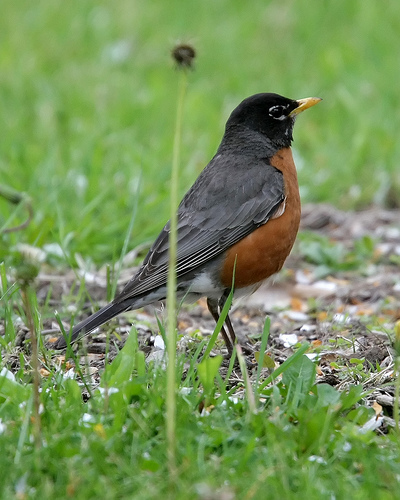

In [14]:
img = Image.open(fnames[315])
img

In [15]:
# ImageNetの学習済み重みを使うための画像前処理
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

In [16]:
# ネットワークから生成される画像を表示するには上の逆の処理が必要
deproc = lambda x, s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [17]:
img_arr = preproc(np.expand_dims(np.array(img), 0))
shp = img_arr.shape
shp

(1, 500, 400, 3)

## Reconstruct content

- 論文のFigure1のContent Reconstructionsの部分

In [16]:
model = VGG16_Avg(include_top=False)

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

In [144]:
target = 'block5_conv1'
layer = model.get_layer(target).output

In [145]:
layer

<tf.Tensor 'block5_conv1/Relu:0' shape=(?, ?, ?, 512) dtype=float32>

In [146]:
# 指定したレイヤの出力を出力するモデルを新しく構成する
layer_model = Model(model.input, layer)
layer_model.summary()

# 出力をもとにバックプロパゲーションするので処理できるようにVariable化しておく
# targは特定の画像（img_arrに入っている鳥の絵）を入れたときの出力 Variable になる
# 一方、layerは同じレイヤの出力であるが特定の入力を指定していない Tensor になる
targ = K.variable(layer_model.predict(img_arr))
targ

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, None, None, 128)   0         
__________

<tf.Variable 'Variable_4:0' shape=(1, 31, 25, 512) dtype=float32_ref>

In [31]:
# fmin_l_bfgs_b()を使うにはlossとgradに別々にアクセスできる関数が必要
class Evaluator(object):
    def __init__(self, f, shp):
        # f: lossとgradを返すK.function
        # shp: 入力画像（4D tensor）のサイズ
        self.f, self.shp = f, shp
    
    def loss(self, x):
        # lossとgradがまとめて計算されるのでgradは保存しておく
        loss_, self.grad_values = self.f([x.reshape(self.shp)])
        return loss_.astype(np.float64)

    def grads(self, x):
        # 保存しておいたgradを返す
        return self.grad_values.flatten().astype(np.float64)

In [148]:
# layerはまだ特定の画像を入れていない出力（あとでmodel.inputとして灰色の画像を入れる）
# targは鳥の画像を入れたときの出力
# metrics.mse()はスカラーを返さなくなった？
# K.sum()やK.mean()で囲むとスカラーになる、Keras1ではmseがスカラー返す？？？
loss = K.mean(metrics.mse(layer, targ))

In [149]:
loss

<tf.Tensor 'Mean_17:0' shape=() dtype=float32>

In [150]:
# パラメータではなく、モデルへの入力画像に対する勾配を求める
grads = K.gradients(loss, model.input)

In [151]:
print(type([loss]), type(grads))

<class 'list'> <class 'list'>


In [152]:
[1, 2, 3] + [4, 5, 6]

[1, 2, 3, 4, 5, 6]

In [153]:
# 足し算しても要素がちゃんとわかれている
[loss] + grads

[<tf.Tensor 'Mean_17:0' shape=() dtype=float32>,
 <tf.Tensor 'gradients_7/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>]

In [154]:
# lossとgradsを結合したリストを返す関数
fn = K.function([model.input], [loss] + grads)

In [155]:
evaluator = Evaluator(fn, shp)

In [36]:
def solve_image(eval_obj, niter, x):
    for i in range(niter):
        x, min_val, info = fmin_l_bfgs_b(eval_obj.loss, x.flatten(),
                                         fprime=eval_obj.grads, maxfun=20)
        x = np.clip(x, -127, 127)
        print('Current loss value:', min_val)
        imsave('./results/res_at_iteration_%d.png' % i, deproc(x.copy(), shp)[0])
    return x

(1, 500, 400, 3)


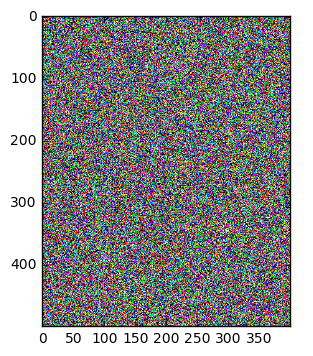

In [157]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 100
x = rand_img(shp)
print(x.shape)
plt.imshow(x[0])

In [158]:
iterations = 10
x = solve_image(evaluator, iterations, x)

Current loss value: 47.4123802185
Current loss value: 14.1513118744
Current loss value: 7.06395435333
Current loss value: 4.57340621948
Current loss value: 3.54282236099
Current loss value: 2.89271831512
Current loss value: 2.46996450424
Current loss value: 2.13306331635
Current loss value: 1.90067148209
Current loss value: 1.67836332321


- 鳥の画像を入力したときのblock5_conv1の出力（targ） に近くなるように入力となるランダムノイズを更新していく

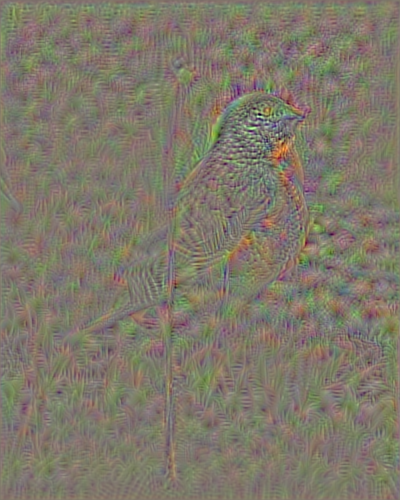

In [159]:
Image.open('results/res_at_iteration_0.png')

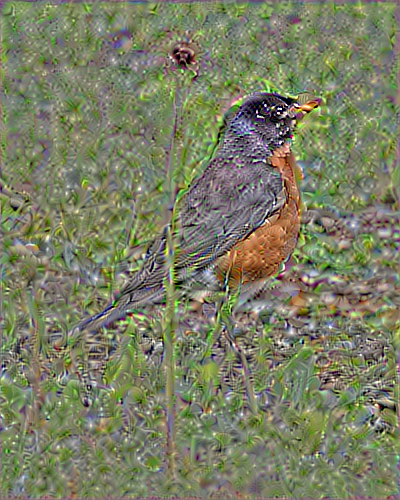

In [160]:
Image.open('results/res_at_iteration_9.png')

In [162]:
%ls results/

res_at_iteration_0.png  res_at_iteration_4.png  res_at_iteration_8.png
res_at_iteration_1.png  res_at_iteration_5.png  res_at_iteration_9.png
res_at_iteration_2.png  res_at_iteration_6.png
res_at_iteration_3.png  res_at_iteration_7.png


In [163]:
from IPython.display import HTML
from matplotlib import animation, rc

In [180]:
def animate(i):
    ax.imshow(Image.open('results/res_at_iteration_%d.png' % i))

In [181]:
anim = animation.FuncAnimation(fig, animate, frames=10, interval=200)
HTML(anim.to_html5_video())

## Reconstruct style

- 論文のFigure1のStyle reconstructions

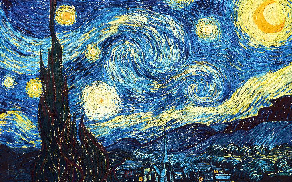

In [18]:
style = Image.open('data/starry_night.jpg')
style = style.resize(np.divide(style.size, 3.5).astype('int32'))
style

In [19]:
style_arr = preproc(np.expand_dims(style, 0)[:, :, :, :3])

In [20]:
np.expand_dims(style, 0).shape

(1, 182, 292, 3)

In [21]:
shp = style_arr.shape

In [22]:
model = VGG16_Avg(include_top=False, input_shape=shp[1:])
model

In [23]:
# layerの名前 => layerの出力Tensorへの辞書
outputs = {l.name: l.output for l in model.layers}
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 182, 292, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 182, 292, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/AvgPool:0' shape=(?, 91, 146, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 91, 146, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 91, 146, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/AvgPool:0' shape=(?, 45, 73, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/AvgPool:0' shape=(?, 22, 36, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 22, 36, 512) dtype=float32>,
 'block4_conv2

In [48]:
# style lossは複数の層の出力を使う
layers = [outputs['block{}_conv1'.format(o)] for o in range(1, 3)]
layers

[<tf.Tensor 'block1_conv1/Relu:0' shape=(?, 182, 292, 64) dtype=float32>,
 <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 91, 146, 128) dtype=float32>,
 <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 22, 36, 512) dtype=float32>,
 <tf.Tensor 'block5_conv1/Relu:0' shape=(?, 11, 18, 512) dtype=float32>]

In [25]:
layers_model = Model(model.input, layers)

- 下の方の層を出力する場合はその前の層も伝搬する必要があるので追加される
- グラフィカルに表示して層間にどのようなつながりがあるか調べられない？

In [26]:
layers_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 182, 292, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 182, 292, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 182, 292, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 91, 146, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 91, 146, 128)      73856     
Total params: 112,576
Trainable params: 112,576
Non-trainable params: 0
_________________________________________________________________


In [27]:
# 実際のスタイル画像（style_arr）を入力したときの各層の出力をターゲットとする
targs = [K.variable(o) for o in layers_model.predict(style_arr)]
targs

[<tf.Variable 'Variable:0' shape=(1, 182, 292, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 91, 146, 128) dtype=float32_ref>]

- コンテンツでは出力のピクセルの差を直接MSEで計算した
- スタイルの場合はチャネルのグラム行列にしてからMSEを計算する

It's unclear why this helps us achieve our goal, but it works. One thought is that the gramian  shows how our features at that convolutional layer correlate, and completely removes all location information. So matching the gram matrix of channels can only match some type of texture information, not location information.

In [28]:
# xはあるレイヤの出力（複数チャネルあり）
# バッチはなくなっている
# 論文の式 (3) に当たる
def gram_matrix(x):
    print("x:", x.shape)
    # (height, width, channel) => (channel, height, width)
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    # チャネル間の内積を取る
    return K.dot(features, K.transpose(features)) / x.get_shape().num_elements()

In [29]:
# 論文の式(4)にあたる
def style_loss(x, targ):
    return K.mean(metrics.mse(gram_matrix(x), gram_matrix(targ)))

In [32]:
# 式(5)のスタイルlossに当たるが重み付けはしていない
loss = sum(style_loss(l1[0], l2[0]) for l1, l2 in zip(layers, targs))
grads = K.gradients(loss, model.input)
style_fn = K.function([model.input], [loss] + grads)
evaluator = Evaluator(style_fn, shp)

x: (182, 292, 64)
features: (?, ?)
x: (182, 292, 64)
features: (?, ?)
x: (91, 146, 128)
features: (?, ?)
x: (91, 146, 128)
features: (?, ?)


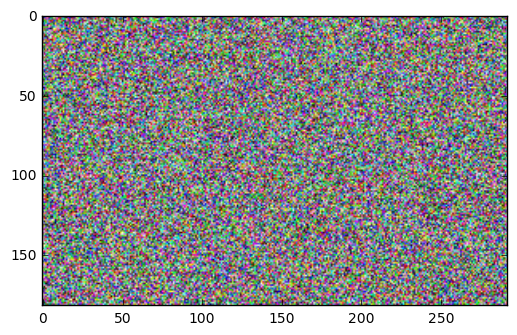

In [45]:
rand_img = lambda shape: np.random.uniform(-2.5, 2.5, shape) / 1
x = rand_img(shp)
plt.imshow(x[0])

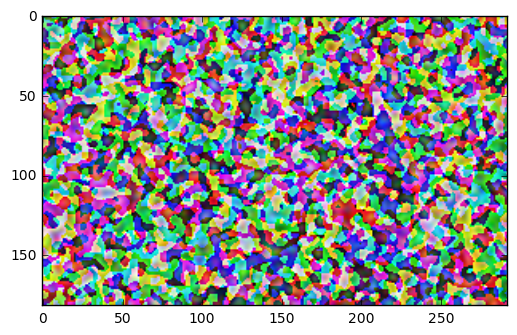

In [46]:
x = scipy.ndimage.filters.gaussian_filter(x, [0, 2, 2, 0])
plt.imshow(x[0])

In [47]:
iterations = 10
x = rand_img(shp)
x = solve_image(evaluator, iterations, x)

Current loss value: 13803.6630859
Current loss value: 545.709716797
Current loss value: 273.413269043
Current loss value: 180.211547852
Current loss value: 129.788238525
Current loss value: 87.4962615967
Current loss value: 63.2466316223
Current loss value: 46.6433105469
Current loss value: 37.808555603
Current loss value: 29.3605651855


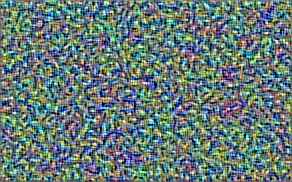

In [49]:
Image.open('results/res_at_iteration_0.png')

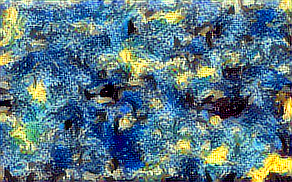

In [50]:
Image.open('results/res_at_iteration_8.png')

## Style transfer

In [68]:
def plot_arr(arr):
    plt.imshow(deproc(arr,arr.shape)[0].astype('uint8'))

(292, 182)
(1, 182, 292, 3)


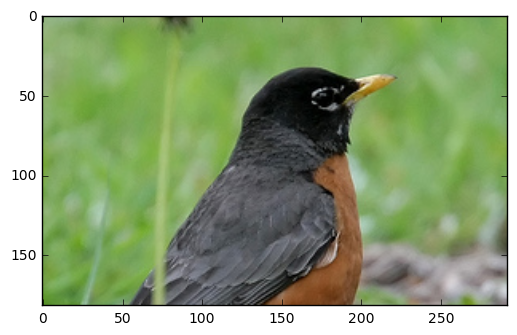

In [90]:
# 使うモデルは1つなのでスタイルのサイズに合わせる必要がある
w, h = style.size
src = img_arr[:, 60:h+60, 100:w+100]
print(style.size)
print(src.shape)
plot_arr(src)

In [80]:
outputs

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(?, 182, 292, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(?, 182, 292, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/AvgPool:0' shape=(?, 91, 146, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(?, 91, 146, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(?, 91, 146, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/AvgPool:0' shape=(?, 45, 73, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(?, 45, 73, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/AvgPool:0' shape=(?, 22, 36, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(?, 22, 36, 512) dtype=float32>,
 'block4_conv2

In [75]:
# block1からblock5のすべての層の出力を使ってスタイルを求める
# スタイルは複数の層の出力を使う
style_layers = [outputs['block{}_conv2'.format(o)] for o in range(1, 6)]

# コンテンツは一つの層の出力を使う
content_layer = outputs['block4_conv2']

In [78]:
# ここの model はスタイル再構成のときのモデルなのでスタイル画像のサイズが入力となる
style_model = Model(model.input, style_layers)
style_targs = [K.variable(o) for o in style_model.predict(style_arr)]
style_targs

[<tf.Variable 'Variable_7:0' shape=(1, 182, 292, 64) dtype=float32_ref>,
 <tf.Variable 'Variable_8:0' shape=(1, 91, 146, 128) dtype=float32_ref>,
 <tf.Variable 'Variable_9:0' shape=(1, 45, 73, 256) dtype=float32_ref>,
 <tf.Variable 'Variable_10:0' shape=(1, 22, 36, 512) dtype=float32_ref>,
 <tf.Variable 'Variable_11:0' shape=(1, 11, 18, 512) dtype=float32_ref>]

In [95]:
content_model = Model(model.input, content_layer)
# 入力はスタイルと同じサイズであることがわかる
content_model.summary()
# 画像を入れたときの出力
content_targ = K.variable(content_model.predict(src))
content_targ

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 182, 292, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 182, 292, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 182, 292, 64)      36928     
_________________________________________________________________
block1_pool (AveragePooling2 (None, 91, 146, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 91, 146, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 91, 146, 128)      147584    
_________________________________________________________________
block2_pool (AveragePooling2 (None, 45, 73, 128)       0         
__________

<tf.Variable 'Variable_13:0' shape=(1, 22, 36, 512) dtype=float32_ref>

In [108]:
style_weights = [0.05, 0.2, 0.2, 0.25, 0.3]

In [161]:
# 重み付けしたスタイルloss 式 (5)
loss = sum(style_loss(l1[0], l2[0]) * w for l1, l2, w in zip(style_layers, style_targs, style_weights))

# コンテンツlossを足し合わせる
# α = 0.001  β = 1.0
# コンテンツ重みとスタイル重みの比を変えられる
loss += K.sum(K.square(content_layer - content_targ)) / 10000.0

grads = K.gradients(loss, model.input)
transfer_fn = K.function([model.input], [loss] + grads)

x: (182, 292, 64)
features: (?, ?)
x: (182, 292, 64)
features: (?, ?)
x: (91, 146, 128)
features: (?, ?)
x: (91, 146, 128)
features: (?, ?)
x: (45, 73, 256)
features: (?, ?)
x: (45, 73, 256)
features: (?, ?)
x: (22, 36, 512)
features: (?, ?)
x: (22, 36, 512)
features: (?, ?)
x: (11, 18, 512)
features: (?, ?)
x: (11, 18, 512)
features: (?, ?)


In [162]:
evaluator = Evaluator(transfer_fn, shp)

In [163]:
iterations = 10
x = rand_img(shp)

In [164]:
x = solve_image(evaluator, iterations, x)


KeyboardInterrupt



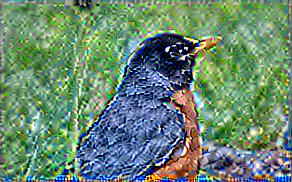

In [165]:
Image.open('results/res_at_iteration_9.png')